In [21]:
import warnings
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import mlflow
from mlflow.models.signature import infer_signature
from mlflow.tracking import MlflowClient

#from pycaret.classification import setup, create_model, predict_model

import pycaret.classification as pc
from pycaret.classification import plot_model

# Ignorar Warning
warnings.filterwarnings('ignore')


## Item 6 - Pipeline de  Processamento de dados

#### Configuração do MLflow

In [22]:
#Usando SQLite como repositório

mlflow.set_tracking_uri("sqlite:///mlruns.db")

experiment_name = 'Projeto_Kobe'
experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment is None:
    experiment_id = mlflow.create_experiment(experiment_name)
    experiment = mlflow.get_experiment(experiment_id)
experiment_id = experiment.experiment_id 

### Item 6
#### Carregamento dos dados / Seleção das colunas / Dimenssão do dataset / separação treino e teste / 

In [23]:
mlflow.end_run()

In [24]:
from sklearn.model_selection import train_test_split

data_colunas = ['lat', 'lon', 'minutes_remaining', 'period', 'playoffs', 'shot_distance', 'shot_made_flag']

train_perc = 0.8

with mlflow.start_run(experiment_id=experiment_id, run_name = 'PreparacaoDados'):
    df_dev = pd.read_parquet('../data/raw/dataset_kobe_dev.parquet')

    data_dev = df_dev.dropna(how="any", axis=0) 

    data_dev = data_dev[data_colunas].copy()

    #Armazenando o dataset na pasta /data/processed 
    data_dev.to_parquet("../data/processed/data_dev_filtered.parquet")

    xtrain, xtest, ytrain, ytest = train_test_split(data_dev[['lat', 'lon', 'minutes_remaining', 'period', 'playoffs', 'shot_distance']],
                                                data_dev['shot_made_flag'],
                                                train_size=train_perc,
                                                stratify=data_dev['shot_made_flag'])
    
    
    xtrain['shot_made_flag'] = ytrain
    xtest['shot_made_flag'] = ytest
    xtrain.to_parquet('../data/processed/base_train.parquet') 
    xtest.to_parquet('../data/processed/base_teste.parquet')
    
    mlflow.log_params({
           'perc-test' : 1-train_perc,
           'colunas-selecionadas': data_colunas
           })
    mlflow.log_metrics({
           'quanti_linhas_treino': xtrain.shape[0],
           'quanti_linhas_teste': xtrain.shape[0]
    })  



In [25]:
data_dev = pd.read_parquet('../data/raw/dataset_kobe_dev.parquet')

In [26]:
df_dev.columns
'lat', 'lon', 'minutes_remaining', 'period', 'playoffs', 'shot_distance'

('lat', 'lon', 'minutes_remaining', 'period', 'playoffs', 'shot_distance')

In [27]:
# Analisando o dataset original
df_dev.head()

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,...,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,...,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,...,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5


In [28]:
# Analisando o dataset considerando apenas as colunas filtradas
data_dev.head()

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,...,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,...,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,...,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5


#### Item 6 - Dimensão resultante do dataset

In [29]:
# Dataset pré exclução de linhas com dados nulos
df_dev.shape        

(24271, 25)

In [30]:
# Dataset pós exclução de linhas com dados nulos
data_dev.shape

(24271, 25)

In [31]:
#Conferindo se existem dados faltantes no dataset
df_dev.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24271 entries, 0 to 30696
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   action_type         24271 non-null  object 
 1   combined_shot_type  24271 non-null  object 
 2   game_event_id       24271 non-null  int64  
 3   game_id             24271 non-null  int64  
 4   lat                 24271 non-null  float64
 5   loc_x               24271 non-null  int64  
 6   loc_y               24271 non-null  int64  
 7   lon                 24271 non-null  float64
 8   minutes_remaining   24271 non-null  int64  
 9   period              24271 non-null  int64  
 10  playoffs            24271 non-null  int64  
 11  season              24271 non-null  object 
 12  seconds_remaining   24271 non-null  int64  
 13  shot_distance       24271 non-null  int64  
 14  shot_made_flag      20285 non-null  float64
 15  shot_type           24271 non-null  object 
 16  shot_zone

In [32]:
# Conferindo se todas as linhas com dados nulos foram excluídas
data_dev.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24271 entries, 0 to 30696
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   action_type         24271 non-null  object 
 1   combined_shot_type  24271 non-null  object 
 2   game_event_id       24271 non-null  int64  
 3   game_id             24271 non-null  int64  
 4   lat                 24271 non-null  float64
 5   loc_x               24271 non-null  int64  
 6   loc_y               24271 non-null  int64  
 7   lon                 24271 non-null  float64
 8   minutes_remaining   24271 non-null  int64  
 9   period              24271 non-null  int64  
 10  playoffs            24271 non-null  int64  
 11  season              24271 non-null  object 
 12  seconds_remaining   24271 non-null  int64  
 13  shot_distance       24271 non-null  int64  
 14  shot_made_flag      20285 non-null  float64
 15  shot_type           24271 non-null  object 
 16  shot_zone

## Item 7 - Implementar o Pipeline de Treinamento

### Treinamento do Modelo

In [33]:
from sklearn.model_selection import validation_curve

def plot_parameter_validation_curve(X, Y, param_name, grid_search,
                                    model, model_name, scoring,
                                    logx):
    print('Parameter:', param_name)
    print('GridSearch:', grid_search[param_name])
    print('Scoring:', scoring)
    plt.figure(figsize=(6,4))
    train_scores, test_scores = validation_curve(model,
                                                 X = X, 
                                                 y = Y, 
                                                 param_name=param_name, 
                                                 param_range= grid_search[param_name],
                                                 scoring=scoring,
                                                 cv=10,
                                                 n_jobs=-1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.title("Curva Validação Modelo " + model_name)
    plt.xlabel(param_name)
    plt.ylabel("Score ("+scoring+")")
    if logx:
        plt.semilogx(grid_search[param_name], train_scores_mean,'-o', label="Treino",
                     color="darkorange", lw=2)
        plt.semilogx(grid_search[param_name], test_scores_mean,'-o', label="Validação-Cruzada",
                     color="navy", lw=2)
    else:
        plt.plot(grid_search[param_name], train_scores_mean,'-o', label="Treino",
                     color="darkorange", lw=2)
        plt.plot(grid_search[param_name], test_scores_mean,'-o', label="Validação-Cruzada",
                 color="navy", lw=2)
    plt.fill_between(grid_search[param_name], train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=2)
    plt.fill_between(grid_search[param_name], test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=2)
    plt.legend(loc='best')
    plt.grid(True)
    
    #plt.show()
    
    return plt.gcf()
 

In [34]:
#mlflow.end_run()

In [35]:
mlflow.sklearn.log_model?

Signature:
mlflow.sklearn.log_model(
    sk_model,
    artifact_path,
    conda_env=None,
    code_paths=None,
    serialization_format='cloudpickle',
    registered_model_name=None,
    signature: mlflow.models.signature.ModelSignature = None,
    input_example: Union[pandas.core.frame.DataFrame, numpy.ndarray, dict, list, ForwardRef('csr_matrix'), ForwardRef('csc_matrix'), str, bytes, tuple] = None,
    await_registration_for=300,
    pip_requirements=None,
    extra_pip_requirements=None,
    pyfunc_predict_fn='predict',
    metadata=None,
)
Docstring:
Log a scikit-learn model as an MLflow artifact for the current run. Produces an MLflow Model
containing the following flavors:

    - :py:mod:`mlflow.sklearn`
    - :py:mod:`mlflow.pyfunc`. NOTE: This flavor is only included for scikit-learn models
      that define `predict()`, since `predict()` is required for pyfunc model inference.

Args:
    sk_model: scikit-learn model to be saved.
    artifact_path: Run-relative artifact path.


,Description,Value
0,Session id,2780
1,Target,shot_made_flag
2,Target type,Binary
3,Original data shape,"(20285, 7)"
4,Transformed data shape,"(20285, 7)"
5,Transformed train set shape,"(16228, 7)"
6,Transformed test set shape,"(4057, 7)"
7,Numeric features,6
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.5409,0.4984,0.5798,0.5170,0.5465,0.0848,0.0854,0.0180
lr,Logistic Regression,0.5775,0.4818,0.4870,0.5669,0.5238,0.1481,0.1495,0.0140


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.5753,0.6001,0.4863,0.5641,0.5223,0.1438,0.1451


Parameter: C
GridSearch: [0.001, 0.01, 0.1, 1, 10]
Scoring: f1


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Decision Tree Classifier,0.5272,0.5085,0.5653,0.5044,0.5331,0.0575,0.0578


Parameter: max_depth
GridSearch: [2, 3, 4, 5, 6, 7, 8]
Scoring: f1


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5909,0.5000,0.5329,0.5776,0.5544,0.1774,0.1779
1,0.5687,0.4927,0.4452,0.5610,0.4964,0.1279,0.1305
2,0.5490,0.5000,0.4645,0.5318,0.4959,0.0912,0.0919
3,0.5625,0.5000,0.4735,0.5486,0.5083,0.1181,0.1191
4,0.5755,0.5077,0.4258,0.5749,0.4893,0.1396,0.1442
5,0.5650,0.5006,0.4942,0.5495,0.5204,0.1244,0.1250
6,0.5601,0.5000,0.4690,0.5450,0.5042,0.1128,0.1138
7,0.5650,0.4929,0.4974,0.5484,0.5217,0.1245,0.1250
8,0.5635,0.5000,0.4561,0.5516,0.4993,0.1185,0.1202


Fitting 10 folds for each of 4 candidates, totalling 40 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Decision Tree Classifier,0.5272,0.5085,0.5653,0.5044,0.5331,0.0575,0.0578


Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Loaded


Registered model 'modelo_Kobe' already exists. Creating a new version of this model...
Created version '10' of model 'modelo_Kobe'.


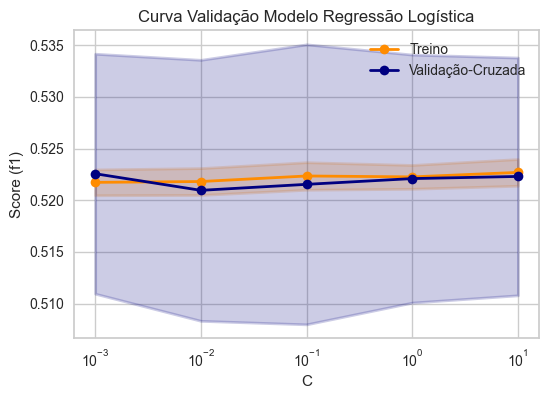

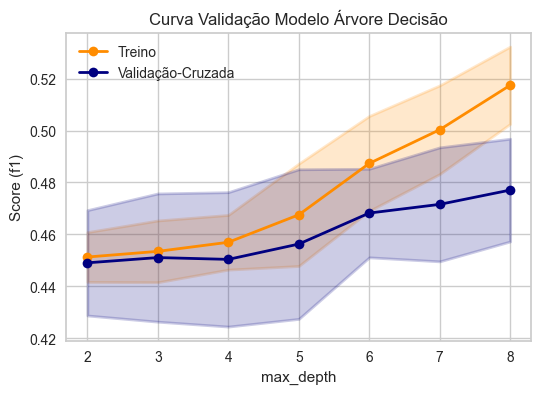

In [36]:
# TESTE TESTE TESTE
import os
from sklearn.metrics import log_loss, f1_score

registered_model_name = 'modelo_Kobe'
nexamples = 5
model_version = -1

with mlflow.start_run(experiment_id=experiment_id, run_name = 'Treinamento'):
  
    exp = pc.setup(
        data=xtrain,
        target = 'shot_made_flag',
        test_data = xtest,
        normalize=True,
        log_experiment = False
    )
    list_models = exp.compare_models(['lr','dt'], n_select=2, sort='f1')

    # REGRESSAO LOGISTICA
   
    yhat_test = exp.predict_model(list_models[1])
    plot_parameter_validation_curve(xtrain.drop('shot_made_flag', axis=1), ytrain, 'C', {'C': [0.001, 0.01, 0.1, 1, 10]},
                                   list_models[1], 'Regressão Logística', 'f1', logx=True)
    
   
    
    mlflow.log_metrics({
        'lr_log_loss': log_loss(yhat_test.shot_made_flag, yhat_test.prediction_label),
        'lr_f1': f1_score(yhat_test.shot_made_flag, yhat_test.prediction_label),
    })
    
     
    plt.savefig('lr_validation_curve.png')
    mlflow.log_artifact('lr_validation_curve.png')
 
 
       
    # ARVORE DE DECISÃO
    yhat_test = exp.predict_model(list_models[0])
    plot_parameter_validation_curve(xtrain.drop('shot_made_flag', axis=1), ytrain, 'max_depth', {'max_depth': [2, 3, 4, 5, 6, 7, 8]},
                                    list_models[0], 'Árvore Decisão', 'f1', logx=False)
    mlflow.log_metrics({
        'dt_log_loss': log_loss(yhat_test.shot_made_flag, yhat_test.prediction_label),
        'dt_f1': f1_score(yhat_test.shot_made_flag, yhat_test.prediction_label),
    })
    
    plt.savefig('dt_validation_curve.png')
    mlflow.log_artifact('dt_validation_curve.png')
 
  

       
     # FINALIZACAO MELHOR MODELO
    tune_model = exp.tune_model(list_models[0],
                                optimize = 'f1',
                                search_library = 'scikit-learn',
                                search_algorithm = 'random',
                                n_iter = 4)
    
    yhat_test = exp.predict_model(tune_model, raw_score=True)  
    mlflow.log_metrics({
        'final_model_log_loss': log_loss(yhat_test.shot_made_flag, yhat_test.prediction_label),
        'final_model_f1': f1_score(yhat_test.shot_made_flag, yhat_test.prediction_label),
    })
    
    yhat_test.to_parquet('../data/processed/prediction_test.parquet')
    mlflow.log_artifact('../data/processed/prediction_test.parquet')
    
    yhat_test.to_parquet('../data/processed/prediction_test.parquet')
    mlflow.log_artifact('../data/processed/prediction_test.parquet')
   
    
    
    final_model = exp.finalize_model(tune_model)
    
    # EXPORTANDO PARA LOGAR E REGISTRAR O MODELO
    
    exp.save_model(final_model, f'./{registered_model_name}') 
    
    # Carregando novamente o pipeline + bestmodel
    model_pipe = exp.load_model(f'./{registered_model_name}')
    
    # Assinatura do Modelo Inferida pelo MLFlow
    model_features = list(xtrain.drop('shot_made_flag', axis=1).columns)
    inf_signature = infer_signature(xtrain[model_features], 
                                    model_pipe.predict_proba(xtrain.drop('shot_made_flag', axis=1)))
    
    # Esse é um exemplo de entrada para o MLmodel
    input_example = {x: xtrain[x].values[:nexamples] for x in model_features}
    
    # Log do pipeline de modelagem do sklearn e registrando-o como uma nova versao
    mlflow.sklearn.log_model(
        sk_model=model_pipe,
        artifact_path="sklearn-model",
        registered_model_name=registered_model_name,
        signature = inf_signature,
        input_example = input_example,
        pyfunc_predict_fn='predict_proba'
    )
    
    # Criando um cliente do servico MLFlow e atualizacao versao modelo
    client = MlflowClient()
    if model_version == -1:
       model_version = client.get_latest_versions(registered_model_name)[-1].version
        
    # Registrando o modelo como staging
    client.set_registered_model_alias(
        name    = registered_model_name, 
        alias   = "staging", 
        version = model_version
    )

In [37]:
import pycaret; print(pycaret.__version__)

3.3.0


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Decision Tree Classifier,0.5272,0.5085,0.5653,0.5044,0.5331,0.0575,0.0578


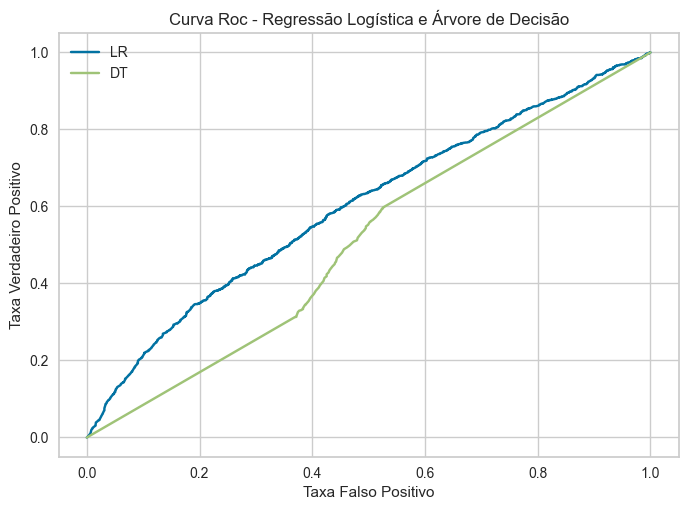

In [38]:
##Curva ROC / pg 19
from sklearn.metrics import roc_curve

yhat_test = exp.predict_model(list_models[1], raw_score=True)
fpr, tpr, thr = roc_curve(yhat_test.shot_made_flag, yhat_test.prediction_score_1)
plt.plot(fpr,tpr, label='LR')

yhat_test = exp.predict_model(list_models[0], raw_score=True)
fpr, tpr, thr = roc_curve(yhat_test.shot_made_flag, yhat_test.prediction_score_1)
plt.plot(fpr,tpr, label='DT')

plt.ylabel('Taxa Verdadeiro Positivo')
plt.xlabel('Taxa Falso Positivo')

plt.legend()

plt.title('Curva Roc - Regressão Logística e Árvore de Decisão')

plt.savefig('Curva_Roc.png')
mlflow.log_artifact('Curva_Roc.png')

In [39]:
#mlflow.get_model_version()

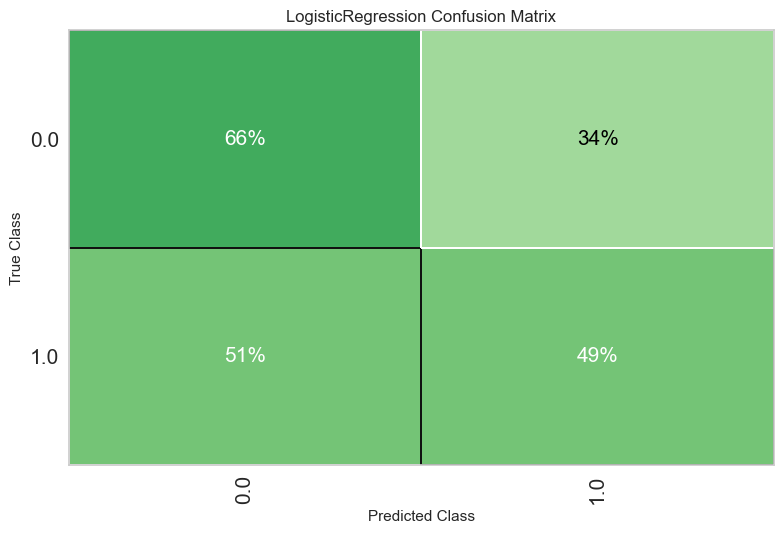

<Figure size 800x550 with 0 Axes>

<Figure size 800x550 with 0 Axes>

In [66]:
# Matriz de confusão - Regressão
plot_model(list_models[1], plot = 'confusion_matrix', plot_kwargs = {'percent' : True})

plt.show()
plt.savefig('lr_Matriz_Confusão.png')
mlflow.log_artifact('lr_Matriz_Confusão.png')


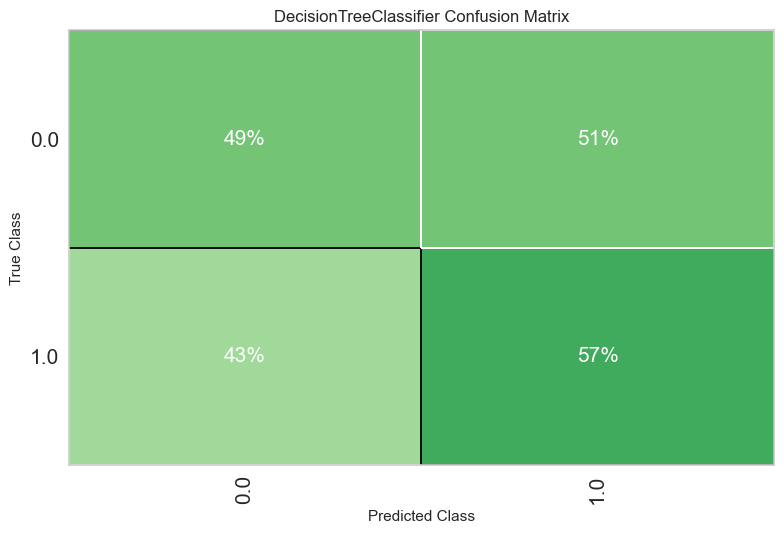

<Figure size 800x550 with 0 Axes>

In [67]:
# # Matriz de confusão - Árvore

plot_model(list_models[0], plot = 'confusion_matrix', plot_kwargs = {'percent' : True})

dt_m_c = plt.gcf()
#plt.show()
plt.draw()
plt.savefig('dt_Matriz_Confusão.png')
mlflow.log_artifact('dt_Matriz_Confusão.png')


